In [7]:
# Section 1 - Imports
# -------------------

# imports
import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join
import copy

# DSO modules
from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec, to_attoseconds
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

In [8]:
# Section 2.1 – Define Files needed for analysis
# -----------------------------------------------
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "s6arx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")
vmf3_data = join(data_path, "y2024.vmf3_d")

In [9]:
# Section 2.2 - Load Orbit Data + Initialize Interpolator
# -------------------------------------------------------
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')

In [10]:
# Section 2.3 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
# ------------------------------------------------------------------------

rnx = DorisRinex(drinex)

site_name = 'DIOB'
result = sinex.extract_sinex_coordinates(dpod, [site_name], rnx.time_first_obs, True, dpod_freq_corr)
rsta = np.array([result[site_name]['X'], result[site_name]['Y'], result[site_name]['Z']])

# we are also going to need the geodetic coordinates of the site
lat, lon, hgt = transformations.car2ell(*rsta)

In [11]:
# Section 2.4 - Initialize VMF3 from (DORIS) site data
# ----------------------------------------------------
vmf = SiteVmf3(vmf3_data, [site_name])

In [46]:
# Section 4 – Preprocess Doppler observations L2GHz
# -------------------------------------------------

# Helper variables to assist analysis
tai_prev = None    # time of last observation if any [TAI]
cp_prev = None     # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0    # current pass index

# globals
CUTOFF_ANGLE = np.radians(10) # cut-off angle at 10 [deg]
C = 299792458e0 # speed of light in vacum, [m/sec]

# nominal transmitting frequencies for DIOB
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))
feN = frN = s1

# Apply PCO to 2GHz phase center at beacon
rsta = rsta + transformations.geodetic2lvlh(lat, lon) @ np.array([0e0, 0e0, 487e-3])

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass
            if tai_prev is None or (tai-tai_prev).total_seconds() > 200.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal emission time; store into an array
            satx, saty, satz, _, _ = alg.sat_at_emission_time(rsta, tai, intrp, 'L40')
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, diob_xyz)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
                # compute a-priori tropospheric delay
                dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
    
                # Phase measurements at 2GHz carrier
                L2ghz = data['L1']['value']
    
                # apply frequency offset - get true receiver frequency
                frT = frN * (1 + data['F']['value'] * 1e-11)
    
                # if we have a previous measurement, within 10 sec ...
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [seconds]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                    # measured part of the obs. equation
                    rr_observed = (C / feN) * (feN - frT - (L2ghz-cp_prev)/dt) + (dtropo-dtropo_prev)
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta) - np.linalg.norm(rsat_prev-rsta)) / dt
                    residuals.append(rr_observed+rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev = tai
                cp_prev = L2ghz
                dtropo_prev = dtropo
                rsat_prev = rsat
                    
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")

Number of Doppler observations extracted: 878
Residal mean value: -2.9 and std. deviation = 0.12


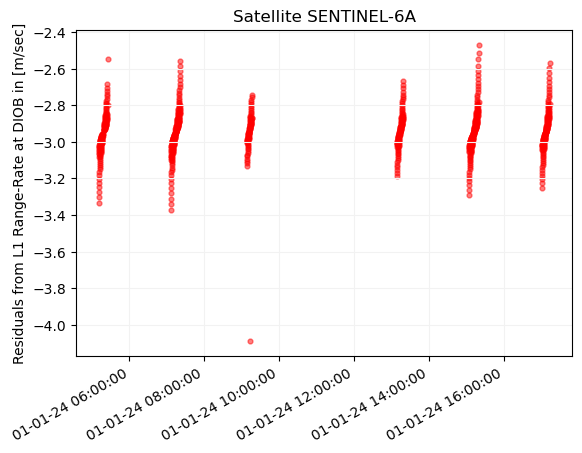

In [44]:
# Section 7.1 - Residual plot

plt.scatter([at2pt(ti) for ti in epochs], residuals, alpha=0.5, s=12, c='red')

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

In [48]:
# Section 4 – Preprocess Doppler observations Iono-Free LC
# --------------------------------------------------------

# Helper variables to assist analysis
tai_prev = None    # time of last observation if any [TAI]
cp_prev = None     # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0    # current pass index

# globals
CUTOFF_ANGLE = np.radians(10) # cut-off angle at 10 [deg]
C = 299792458e0 # speed of light in vacum, [m/sec]

# nominal transmitting frequencies for DIOB
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))
sqrt_gamma = s1 / u2
gamma = sqrt_gamma * sqrt_gamma
feN = frN = (gamma * s1 - sqrt_gamma * u2) / (gamma-1.)
def iflc(L2ghz, L400mhz):
    return (gamma * L2ghz - sqrt_gamma * L400mhz) / (gamma-1.)
print(f'Nominal frequencies S1={s1*1e-6:.1f}GHz (or {C/s1:.3f} m.), U2={u2*1e-3:.1f}MHz (or {C/u2:.3f} m.)')
print(f'Iono-Free LC frequency L3={feN*1e-6:.1f}GHz or {C/feN:.3f} m.')
assert feN == frN

# Apply PCO to 2GHz phase center at beacon
rsta = rsta + transformations.geodetic2lvlh(lat, lon) @ np.array([0e0, 0e0, 487e-3])

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass
            if tai_prev is None or (tai-tai_prev).total_seconds() > 200.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal emission time; store into an array
            satx, saty, satz, _, _ = alg.sat_at_emission_time(rsta, tai, intrp, 'L40')
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, diob_xyz)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
                # compute a-priori tropospheric delay
                dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
    
                # Phase measurements at 2GHz carrier
                L2ghz = data['L1']['value']
                L400mhz = data['L2']['value']
                Lif = iflc(L2ghz, L400mhz)
    
                # apply frequency offset - get true receiver frequency
                frT = frN * (1 + data['F']['value'] * 1e-11)
    
                # if we have a previous measurement, within 10 sec ...
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [seconds]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                    # measured part of the obs. equation
                    rr_observed = (C / feN) * (feN - frT - (Lif-cp_prev)/dt) + (dtropo-dtropo_prev)
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta) - np.linalg.norm(rsat_prev-rsta)) / dt
                    residuals.append(rr_observed+rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev = tai
                cp_prev = Lif
                dtropo_prev = dtropo
                rsat_prev = rsat
                    
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")

Nominal frequencies S1=2036.2GHz (or 0.147 m.), U2=401250.0MHz (or 0.747 m.)
Iono-Free LC frequency L3=2036.2GHz or 0.147 m.
Number of Doppler observations extracted: 878
Residal mean value: -2.9 and std. deviation = 0.12
